# DSC550-T301 Data Mining
## Week 5: 5.2 Exercise: Build your own Sentiment Analysis Model / Daniel Solis Toro

1. Import the movie review data

In [18]:
# Import libraries
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load the dataset
df = pd.read_csv("labeledTrainData.tsv", sep="\t")

2. Prepare text 

In [20]:
# convert to lowercase
df['clean_review'] = df['review'].str.lower()

#remove punctuation and special characters
df['clean_review'] = df['clean_review'].apply(
    lambda x: re.sub(r'[^a-z\s]', '', x))

#Remover stop words
stop_words = set(stopwords.words('english'))

df['clean_review'] = df['clean_review'].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words]))

#Apply Porter Stemmer
ps = PorterStemmer()

df['stemmed_review'] = df['clean_review'].apply(
    lambda x: " ".join([ps.stem(word) for word in x.split()])
)



3. Split into training and test sets

In [22]:
from sklearn.model_selection import train_test_split

X = df['stemmed_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


4. TF-IDF Vectorization

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

# Fit + transform on training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform ONLY on test data
X_test_tfidf = tfidf.transform(X_test)

### Why do we NOT fit TF-IDF on the test set? 
Because fitting on the test set would cause data leakage.
TF-IDF learns vocabulary and word importance statistics.
If we fit on the test set, the model would indirectly “see” test data during training, leading to overly optimistic performance estimates.

5. Train Logistic Regression model

In [27]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

6. Model accuracy on the test set

In [29]:
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8832

7. Confusion Matrix

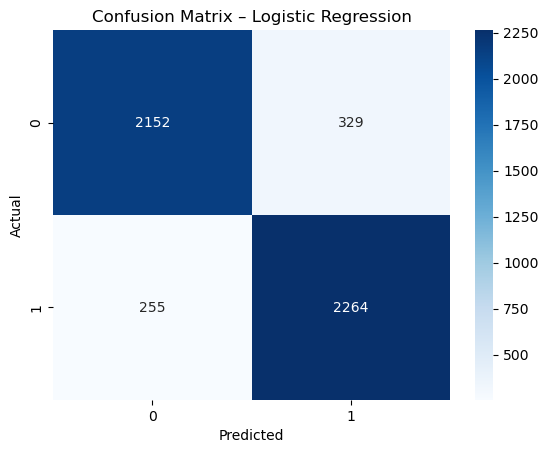

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


7. Precision, Recall, F1-Score

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2481
           1       0.87      0.90      0.89      2519

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



8. ROC Curve

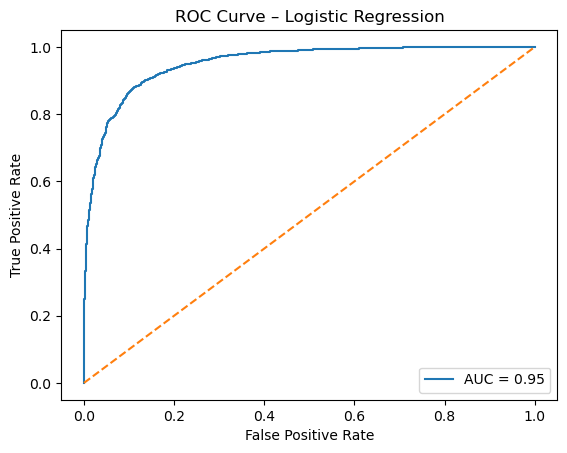

In [42]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_probs = log_reg.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()


## Second model: Naive Bayes

1. Train the model

In [46]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)


MultinomialNB()

2. Accuracy

In [49]:
y_pred_nb = nb.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

accuracy_nb


0.8486

3. Confusion Matrix

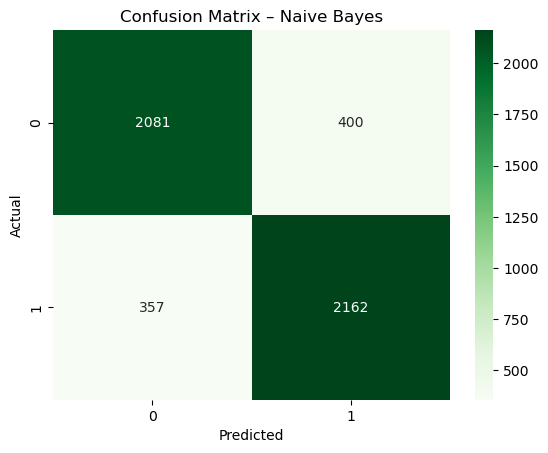

In [52]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Naive Bayes")
plt.show()


4. Precision, Recall, F1-Score

In [55]:
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2481
           1       0.84      0.86      0.85      2519

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



5. ROC Curve 

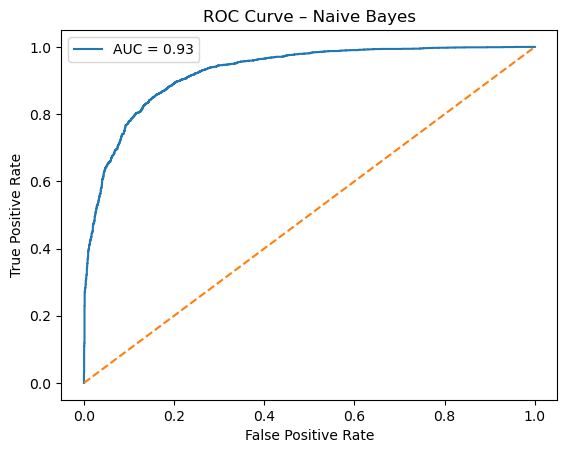

In [58]:
y_probs_nb = nb.predict_proba(X_test_tfidf)[:, 1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.plot(fpr_nb, tpr_nb, label=f"AUC = {roc_auc_nb:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes")
plt.legend()
plt.show()